<a href="https://colab.research.google.com/github/MohdSahil8595/Logistic_Regression/blob/main/PRODIGY_ML_04Hand_Geasture_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install mediapipe opencv-python scikit-learn numpy matplotlib joblib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 65.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 8.9 MB/s eta 0:00:00
  Attempting uninstall: absl-py
    Found existing installation: absl-py 1.4.0
    Uninstalling absl-py-1.4.0:
      Successfully uninstalled absl-py-1.4.0


In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# MediaPipe Tasks API (NEW)
import mediapipe as mp
from mediapipe.tasks.python import BaseOptions
from mediapipe.tasks.python import vision

# ML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

import joblib

In [5]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mohdsahil8595","key":"8c25fd68e109e2836d05e62be44bbbd4"}'}

In [6]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [7]:
!pip install kaggle

In [8]:
#!/bin/bash
!kaggle datasets download gti-upm/leapgestrecog

Dataset URL: https://www.kaggle.com/datasets/gti-upm/leapgestrecog
License(s): CC-BY-NC-SA-4.0
100% 2.12G/2.13G [00:32<00:00, 293MB/s]
100% 2.13G/2.13G [00:32<00:00, 69.9MB/s]


In [9]:
!unzip leapgestrecog.zip

Streaming output truncated to the last 5000 lines.
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0001.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0002.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0003.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0004.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0005.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0006.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0007.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0008.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0009.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0010.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0011.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0012.png  
  inflating: leapgestrecog/leapGestRe

In [10]:
df= "/content/leapGestRecog"

In [12]:
print("subjects:", os.listdir(df))

subjects: ['03', '01', '07', '02', '04', '08', '00', '05', '09', '06']


In [13]:
gesture_labels = {
    "01_palm": 0,
    "02_l": 1,
    "03_fist": 2,
    "04_fist_moved": 3,
    "05_thumb": 4,
    "06_index": 5,
    "07_ok": 6,
    "08_palm_moved": 7,
    "09_c": 8,
    "10_down": 9
}

In [15]:
base_options = BaseOptions(model_asset_path="hand_landmarker.task")

options = vision.HandLandmarkerOptions(
    base_options=base_options,
    running_mode=vision.RunningMode.IMAGE,   # REQUIRED
    num_hands=1,
    min_hand_detection_confidence=0.3,
    min_hand_presence_confidence=0.3
)

hand_landmarker = vision.HandLandmarker.create_from_options(options)

In [16]:
def extract_landmarks(image):
    image = cv2.resize(image, (256, 256))
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB)

    mp_image = mp.Image(
        image_format=mp.ImageFormat.SRGB,
        data=image
    )

    result = hand_landmarker.detect(mp_image)
    if not result.hand_landmarks:
        return None

    landmarks = []
    for lm in result.hand_landmarks[0]:
        landmarks.extend([lm.x, lm.y, lm.z])

    return landmarks

In [18]:
subject = os.listdir(df)[0]
gesture = os.listdir(os.path.join(df, subject))[0]
img_path = os.path.join(df, subject, gesture,
                        os.listdir(os.path.join(df, subject, gesture))[0])

img = cv2.imread(img_path)
features = extract_landmarks(img)

print("Feature length:", len(features) if features else "No hand")

Feature length: 63


In [19]:
X, y = [], []
count = 0

for subject in os.listdir(df):
    subject_path = os.path.join(df, subject)

    for gesture in os.listdir(subject_path):
        if gesture not in gesture_labels:
            continue

        label = gesture_labels[gesture]
        gesture_path = os.path.join(subject_path, gesture)

        for img_name in os.listdir(gesture_path):
            img = cv2.imread(os.path.join(gesture_path, img_name))
            if img is None:
                continue

            features = extract_landmarks(img)
            if features:
                X.append(features)
                y.append(label)
                count += 1

            if count % 500 == 0 and count > 0:
                print("Collected:", count)

Collected: 500
Collected: 1000
Collected: 1500
Collected: 2000
Collected: 2500
Collected: 3000
Collected: 3500
Collected: 4000
Collected: 4500
Collected: 5000
Collected: 5500
Collected: 6000
Collected: 6500
Collected: 6500
Collected: 7000
Collected: 7500
Collected: 8000
Collected: 8500
Collected: 9000
Collected: 9500
Collected: 9500
Collected: 9500
Collected: 9500
Collected: 9500
Collected: 10000
Collected: 10000
Collected: 10000
Collected: 10500
Collected: 11000
Collected: 11000
Collected: 11500
Collected: 12000
Collected: 12500
Collected: 12500
Collected: 13000
Collected: 13500
Collected: 14000


In [20]:
print("Length X:", len(X))
print("Length y:", len(y))

X = np.array(X)
y = np.array(y)

print("Samples:", X.shape[0])
print("Features:", X.shape[1])

Length X: 14252
Length y: 14252
Samples: 14252
Features: 63


In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [22]:
model = SVC(kernel="rbf", C=10, gamma="scale")
model.fit(X_train, y_train)

SVC(C=10)

In [23]:
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.9975447211504735
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       320
           1       1.00      1.00      1.00       356
           2       0.99      0.99      0.99       377
           3       1.00      1.00      1.00       140
           4       1.00      1.00      1.00       379
           5       0.98      0.99      0.98       218
           6       1.00      1.00      1.00       383
           7       1.00      1.00      1.00       108
           8       1.00      1.00      1.00       181
           9       1.00      1.00      1.00       389

    accuracy                           1.00      2851
   macro avg       1.00      1.00      1.00      2851
weighted avg       1.00      1.00      1.00      2851



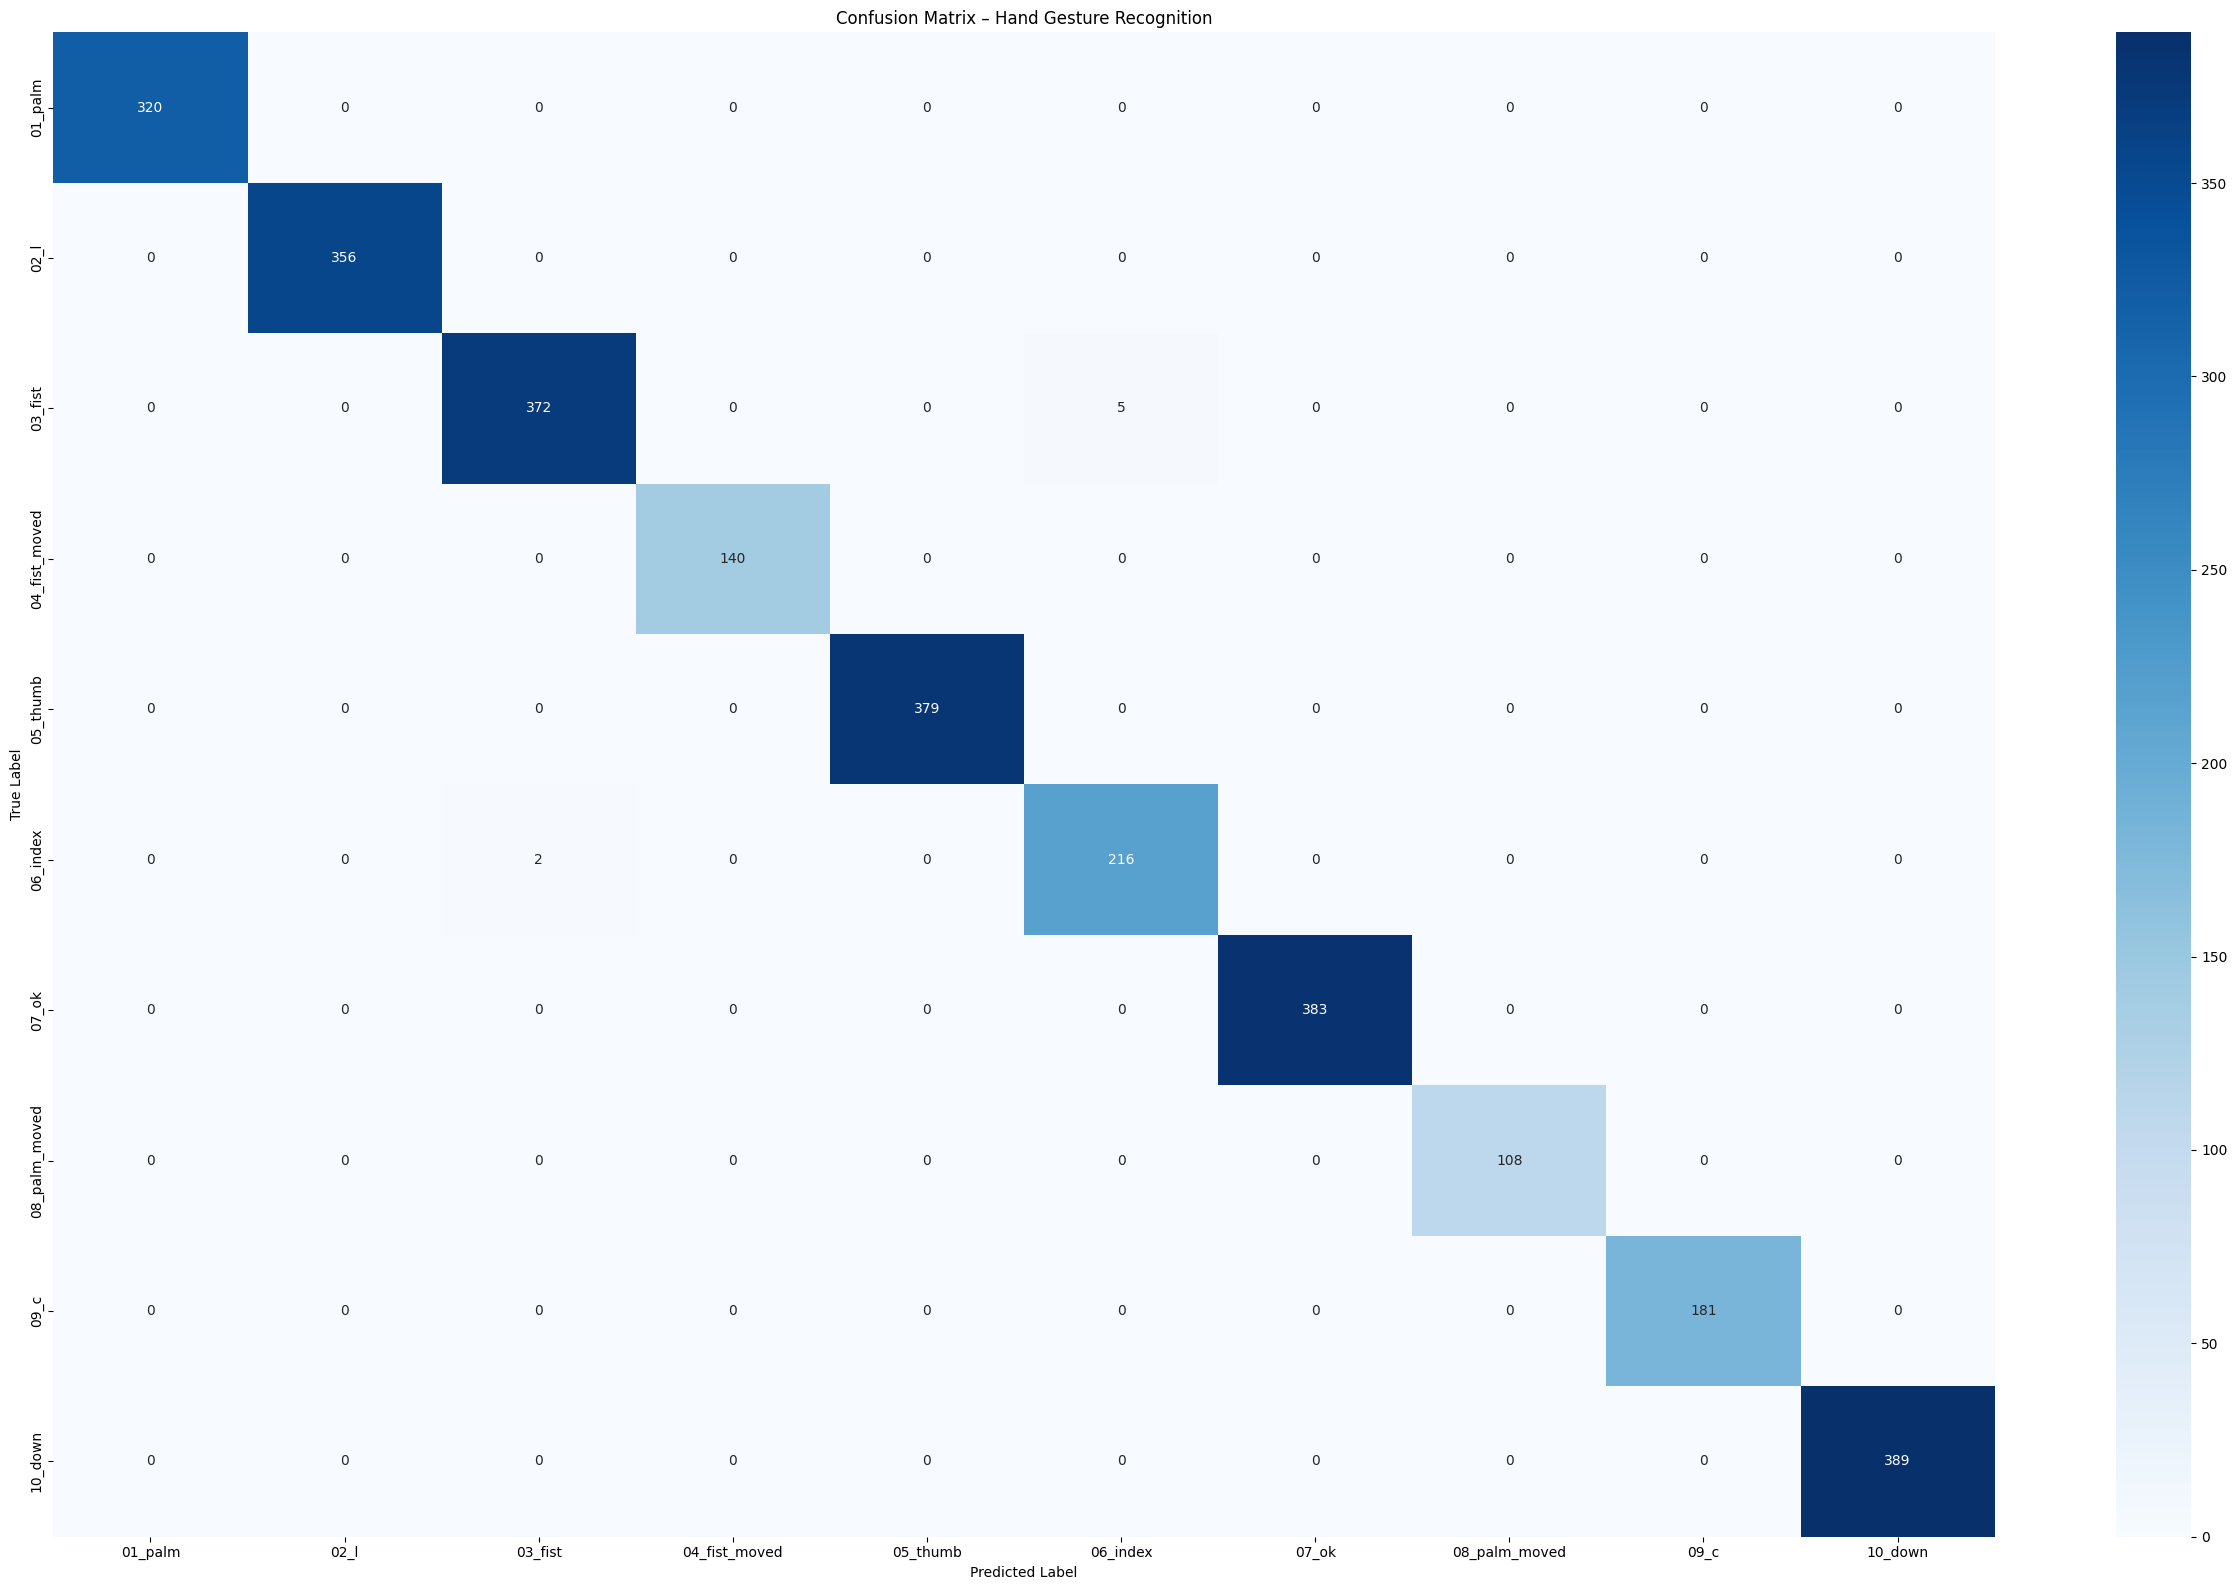

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(25, 16))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=gesture_labels.keys(),
    yticklabels=gesture_labels.keys()
)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix – Hand Gesture Recognition")
plt.tight_layout()
plt.show()

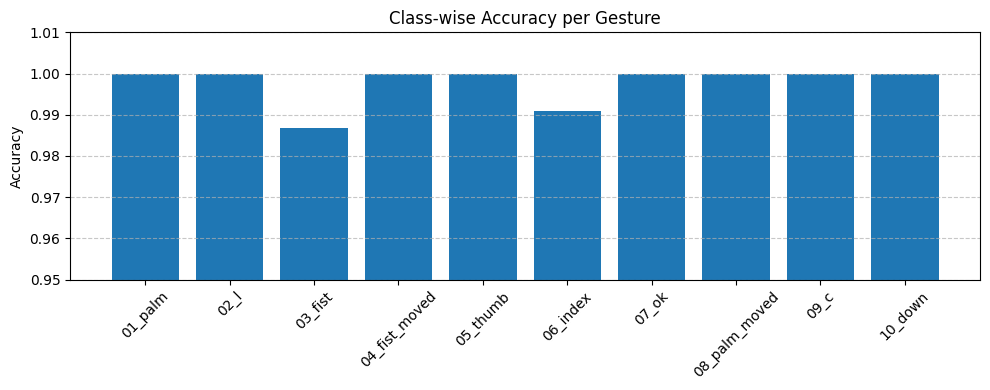

In [25]:
# Class-wise accuracy
class_accuracy = cm.diagonal() / cm.sum(axis=1)

plt.figure(figsize=(10, 4))
plt.bar(gesture_labels.keys(), class_accuracy)

plt.xticks(rotation=45)
plt.ylim(0.95, 1.01)
plt.ylabel("Accuracy")
plt.title("Class-wise Accuracy per Gesture")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

In [26]:
os.makedirs("models", exist_ok=True)

joblib.dump(model, "models/gesture_svm.pkl")
joblib.dump(scaler, "models/scaler.pkl")

print("Model saved")

Model saved


In [27]:
import joblib

model = joblib.load("models/gesture_svm.pkl")
scaler = joblib.load("models/scaler.pkl")

print("Model & scaler loaded")

Model & scaler loaded


In [28]:
label_map = {
    0: "Palm",
    1: "L",
    2: "Fist",
    3: "Fist Moved",
    4: "Thumb",
    5: "Index",
    6: "OK",
    7: "Palm Moved",
    8: "C",
    9: "Down"
}

In [ ]:
cap = cv2.VideoCapture(0)

if not cap.isOpened():
    print("❌ Webcam not accessible")
else:
    print("✅ Webcam started")

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Mirror view
    frame = cv2.flip(frame, 1)

    # Extract landmarks
    features = extract_landmarks(frame)

    if features is not None:
        features = np.array(features).reshape(1, -1)
        features = scaler.transform(features)

        prediction = model.predict(features)[0]
        gesture = label_map[prediction]

        cv2.putText(
            frame,
            f"Gesture: {gesture}",
            (30, 50),
            cv2.FONT_HERSHEY_SIMPLEX,
            1,
            (0, 255, 0),
            2
        )
    else:
        cv2.putText(
            frame,
            "No Hand Detected",
            (30, 50),
            cv2.FONT_HERSHEY_SIMPLEX,
            1,
            (0, 0, 255),
            2
        )

    cv2.imshow("Real-Time Hand Gesture Recognition", frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()